In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.filterwarnings('ignore')

from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize, RegexpTokenizer, sent_tokenize
from nltk.corpus import stopwords
from nltk import ne_chunk
from nltk import download
from nltk.stem import SnowballStemmer
#download('maxent_ne_chunker')
#download('words')
#nltk.download('averaged_perceptron_tagger')

from rake_nltk import rake

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from wordcloud import WordCloud, ImageColorGenerator

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Emerald City Travel Recommendations

## Data Preparation

In [2]:
## import dataframes
seattle_coffee_reviews_df = pd.read_csv('seattle_coffee_reviews_df.csv')
seattle_boutique_reviews_df = pd.read_csv('seattle_boutique_reviews_df.csv')
seattle_adult_reviews_df = pd.read_csv('seattle_adult_reviews_df.csv')

In [3]:
# check head
seattle_coffee_reviews_df.head()

,business_name,source_url,review_ratings,review_text
0,Armistice Coffee Roaster,https://www.yelp.com/biz/armistice-coffee-roas...,1.0,Iced mocha and hot mocha were flavorless. Tast...
1,Armistice Coffee Roaster,https://www.yelp.com/biz/armistice-coffee-roas...,4.0,Good coffee. Didn't try any of the pastries. C...
2,Armistice Coffee Roaster,https://www.yelp.com/biz/armistice-coffee-roas...,5.0,Cozy atmosphere. REALLY GOOD almond croissants...
3,Armistice Coffee Roaster,https://www.yelp.com/biz/armistice-coffee-roas...,5.0,What a nice contemporary coffee shop. 3 min wa...
4,Armistice Coffee Roaster,https://www.yelp.com/biz/armistice-coffee-roas...,5.0,"Great coffee, nice baristas, and a cute place ..."


In [4]:
# check head
seattle_boutique_reviews_df.head()

,business_name,source_url,review_ratings,review_text
0,Alexandra’s Designer Consignment,https://www.yelp.com/biz/alexandras-designer-c...,3.0,"I love consignment shops, and I was really exc..."
1,Alexandra’s Designer Consignment,https://www.yelp.com/biz/alexandras-designer-c...,3.0,This is a large store full of dated designer c...
2,Alexandra’s Designer Consignment,https://www.yelp.com/biz/alexandras-designer-c...,5.0,I recently bought an 18 Karat gold chain here....
3,Alexandra’s Designer Consignment,https://www.yelp.com/biz/alexandras-designer-c...,5.0,I regularly shop at Alexandra's-anytime I need...
4,Alexandra’s Designer Consignment,https://www.yelp.com/biz/alexandras-designer-c...,2.0,Not impressed. I had really high hopes for thi...


In [5]:
# check head
seattle_adult_reviews_df.head()

,business_name,source_url,review_ratings,review_text
0,White Horse Tavern,https://www.yelp.com/biz/white-horse-tavern-se...,5.0,Love this little neighborhood hood gem. The be...
1,White Horse Tavern,https://www.yelp.com/biz/white-horse-tavern-se...,4.0,"Great tavern, great drinks and great service. ..."
2,White Horse Tavern,https://www.yelp.com/biz/white-horse-tavern-se...,1.0,This place is something that is rare in states...
3,White Horse Tavern,https://www.yelp.com/biz/white-horse-tavern-se...,5.0,I come from Switzerland and have to say do you...
4,White Horse Tavern,https://www.yelp.com/biz/white-horse-tavern-se...,5.0,Recommend the strong island ice tea and house ...


In [6]:
seattle_adult_reviews_df['review_text'][0]

'Love this little neighborhood hood gem. The best 3$ hour whiskey and a transporting vibe. Makes you feel like your in A real Irish Pub.'

Check out basic info on dataframes.

In [7]:
# check info
seattle_coffee_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7478 entries, 0 to 7477
Data columns (total 4 columns):
business_name     7478 non-null object
source_url        7478 non-null object
review_ratings    7478 non-null float64
review_text       7478 non-null object
dtypes: float64(1), object(3)
memory usage: 233.8+ KB


In [8]:
# check info
seattle_boutique_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 4 columns):
business_name     2120 non-null object
source_url        2120 non-null object
review_ratings    2120 non-null float64
review_text       2120 non-null object
dtypes: float64(1), object(3)
memory usage: 66.4+ KB


In [9]:
# check info
seattle_adult_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10042 entries, 0 to 10041
Data columns (total 4 columns):
business_name     10042 non-null object
source_url        10042 non-null object
review_ratings    10042 non-null float64
review_text       10042 non-null object
dtypes: float64(1), object(3)
memory usage: 313.9+ KB


### Remove Reviews with Less Than Four Stars

Because the purpose of our application is to make recommendations to places the user would enjoy we will only be interested in looking at positive reviews. 

In [10]:
# check distribution of review ratings
seattle_coffee_reviews_df['review_ratings'].value_counts(normalize=True).reset_index(drop=True)

0    0.568601
1    0.237630
2    0.085986
3    0.054426
4    0.053357
Name: review_ratings, dtype: float64

In [11]:
# check distribution of review ratings
seattle_boutique_reviews_df['review_ratings'].value_counts(normalize=True).reset_index(drop=True)

0    0.650000
1    0.197170
2    0.063208
3    0.052830
4    0.036792
Name: review_ratings, dtype: float64

In [12]:
# check distribution of review ratings
seattle_adult_reviews_df['review_ratings'].value_counts(normalize=True).reset_index(drop=True)

0    0.541127
1    0.249552
2    0.086238
3    0.075782
4    0.047301
Name: review_ratings, dtype: float64

We will only be losing 19% and 15% of our coffee and boutique reviews, respectively, by excluding any review with less than four stars. Therefore, we will only keep reviews with four or five star ratings.

In [13]:
# filter out all reviews with less than four stars
seattle_coffee_reviews_df = seattle_coffee_reviews_df[seattle_coffee_reviews_df['review_ratings'].isin([4.0,5.0])]
seattle_boutique_reviews_df = seattle_boutique_reviews_df[seattle_boutique_reviews_df['review_ratings'].isin([4.0,5.0])]
seattle_adult_reviews_df = seattle_adult_reviews_df[seattle_adult_reviews_df['review_ratings'].isin([4.0,5.0])]

We will create a list of our dataframes so that we may loop through the list and perform operations on our dataframes simultaneously. 

In [14]:
# create list of dataframes
seattle_review_dataframes = [seattle_coffee_reviews_df, seattle_boutique_reviews_df, seattle_adult_reviews_df]

### Expand the Contractions

We may use a dictionary to expand the English contractions (for example, "shouldn't, can't"). The following dictionary and code is courtesy of Analytics Vidhya. 

However, in order to properly apply the provided dictionary, we must first lowercase every string in our 'review_text' column. 

In [15]:
string = "Uppercase String"

In [16]:
string.lower()

'uppercase string'

In [17]:
# make all reviews lowercase
seattle_coffee_reviews_df['review_text'] = seattle_coffee_reviews_df['review_text'].apply(lambda x: x.lower())
seattle_boutique_reviews_df['review_text'] = seattle_boutique_reviews_df['review_text'].apply(lambda x: x.lower())
seattle_adult_reviews_df['review_text'] = seattle_adult_reviews_df['review_text'].apply(lambda x: x.lower())

In [18]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

In [19]:
# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
for df in seattle_review_dataframes:
    df['review_text']=df['review_text'].apply(expand_contractions)

In [20]:
# check it out
seattle_coffee_reviews_df['review_text'][1]

'good coffee. did not try any of the pastries. comfy space. it was right below my airbnb so it was super convenient. the barristas were polite but indifferent.'

### Tokenizing Review Data

Our first step here will be to tokenize our review data. To do this we will borrow a function used in our "Predicting Review Usefulness" notebook. This function is used to tokenize a review, remove all stop words, remove punctuation, lowercase all words, and return our cleaned tokens. We will edit this function so that it removes the page breaks, first. 

In [21]:
# create sample string
string = "I\'m a sample string. <br> Nailed it. \xa0Check me out."

In [22]:
# define tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# define stop words
stop_words = set(stopwords.words('english'))

def tokenize_review(review):
    # replace <br> breaks with spaces
    review = review.replace("<br>", ' ')
    # make all characters lowercase
    review = review.lower()
    # create tokens, use regex to remove all punctuation
    tokens = tokenizer.tokenize(review)
    # remove stopwords
    clean_tokens = [token for token in tokens if not token in stop_words]
    return clean_tokens

In [23]:
# check function
tokenize_review(string)

['sample', 'string', 'nailed', 'check']

In [24]:
# apply function to dataframes
for df in seattle_review_dataframes:
    df['review_tokens'] =  df['review_text'].apply(tokenize_review)

In [25]:
# check head
seattle_boutique_reviews_df.head()

,business_name,source_url,review_ratings,review_text,review_tokens
2,Alexandra’s Designer Consignment,https://www.yelp.com/biz/alexandras-designer-c...,5.0,i recently bought an 18 karat gold chain here....,"[recently, bought, 18, karat, gold, chain, jew..."
3,Alexandra’s Designer Consignment,https://www.yelp.com/biz/alexandras-designer-c...,5.0,i regularly shop at alexandra is-anytime i nee...,"[regularly, shop, alexandra, anytime, need, ce..."
5,Alexandra’s Designer Consignment,https://www.yelp.com/biz/alexandras-designer-c...,5.0,i found too much here! it is such a great stor...,"[found, much, great, store, even, chanel, swea..."
6,Alexandra’s Designer Consignment,https://www.yelp.com/biz/alexandras-designer-c...,4.0,this is a very big consignment store - one of ...,"[big, consignment, store, one, biggest, seen, ..."
7,Alexandra’s Designer Consignment,https://www.yelp.com/biz/alexandras-designer-c...,4.0,awesome way to free your closet up from things...,"[awesome, way, free, closet, things, want, see..."


### Key Word Extraction

In addition to using our review tokens, we will also create a column using NLTK's key word extractor. "RAKE short for Rapid Automatic Keyword Extraction algorithm, is a domain independent keyword extraction algorithm which tries to determine key phrases in a body of text by analyzing the frequency of word appearance and its co-occurance with other words in the text."

We will analyze tf-idf on both token lists and see which provides better recommendations. 

In [26]:
# initialize rake
r = rake.Rake()

In [27]:
# define key word extractor function
def key_word_extractor(review):
    # extracting the words by passing the text
    r.extract_keywords_from_text(review)

    # get the dictionary with key words and scores
    key_words_dict_scores = r.get_word_degrees()

    # return list of key words
    return list(key_words_dict_scores.keys())

In [28]:
# apply function to dataframes
for df in seattle_review_dataframes:
    df['key_review_tokens'] = df['review_text'].apply(key_word_extractor)

In [29]:
# check to make sure function worked
seattle_coffee_reviews_df.head()

,business_name,source_url,review_ratings,review_text,review_tokens,key_review_tokens
1,Armistice Coffee Roaster,https://www.yelp.com/biz/armistice-coffee-roas...,4.0,good coffee. did not try any of the pastries. ...,"[good, coffee, try, pastries, comfy, space, ri...","[pastries, super, convenient, indifferent, bar..."
2,Armistice Coffee Roaster,https://www.yelp.com/biz/armistice-coffee-roas...,5.0,cozy atmosphere. really good almond croissants...,"[cozy, atmosphere, really, good, almond, crois...","[much, turnover, lot, morning, catch, parking,..."
3,Armistice Coffee Roaster,https://www.yelp.com/biz/armistice-coffee-roas...,5.0,what a nice contemporary coffee shop. 3 min wa...,"[nice, contemporary, coffee, shop, 3, min, wal...","[felt, delicious, put, airbnb, nice, contempor..."
4,Armistice Coffee Roaster,https://www.yelp.com/biz/armistice-coffee-roas...,5.0,"great coffee, nice baristas, and a cute place ...","[great, coffee, nice, baristas, cute, place, g...","[enjoy, coffee, days, nice, baristas, seat, cu..."
5,Armistice Coffee Roaster,https://www.yelp.com/biz/armistice-coffee-roas...,5.0,"cozy new coffee shop and roaster in eastlake,m...","[cozy, new, coffee, shop, roaster, eastlake, p...","[cozy, new, coffee, shop, well, liked, service..."


After further analysis it appears that the 'key_review_tokens' are essentially the same as the 'review_tokens' using our own function. Therrefore, we will simply be using the 'review_tokens' column and will drop the 'key_review_tokens'.

In [30]:
for df in seattle_review_dataframes:
    df.drop('key_review_tokens', axis=1, inplace=True)

### Create Bag of Words

Finally, we will create a bag-of-words. We will write a quick function to create a bag-of-words from our cleaned review tokens. 

In [31]:
# write function to create bag-of-words from list
def bag_of_words(list):
    words = ''
    for word in list:
        words += word + ' '
    return words 

In [32]:
# apply function to dataframes
for df in seattle_review_dataframes:
    df['bag_of_words'] = df['review_tokens'].apply(bag_of_words)

### Aggregate Bag-of-Words Data by Business

We will now want to create new dataframes where we group the token lists together for each business. 

In [33]:
# create new dataframes
seattle_coffee_reviews_grouped = seattle_coffee_reviews_df.groupby('business_name').agg({'bag_of_words': 'sum'})
seattle_boutique_reviews_grouped = seattle_boutique_reviews_df.groupby('business_name').agg({'bag_of_words': 'sum'})
seattle_adult_reviews_grouped = seattle_adult_reviews_df.groupby('business_name').agg({'bag_of_words': 'sum'})

In [34]:
# export to csv for future use
seattle_coffee_reviews_grouped.to_csv('seattle_coffee_reviews_grouped.csv') 
seattle_boutique_reviews_grouped.to_csv('seattle_boutique_reviews_grouped.csv')  
seattle_adult_reviews_grouped.to_csv('seattle_adult_reviews_grouped.csv') 

In [35]:
# check it
seattle_boutique_reviews_grouped.head()

,bag_of_words
business_name,
Alexandra’s Designer Consignment,recently bought 18 karat gold chain jewelry re...
Andaluz,fantastic gift shop great variety gifts unique...
Ballard Consignment Store,going want come prepared strawberries protein ...
Beats & Bohos,amount classics store amazing loved everything...
Bon Voyage Vintage,yet another locally owned family business open...


In [36]:
word_cloud_text = seattle_boutique_reviews_grouped.loc['Andaluz']['bag_of_words']

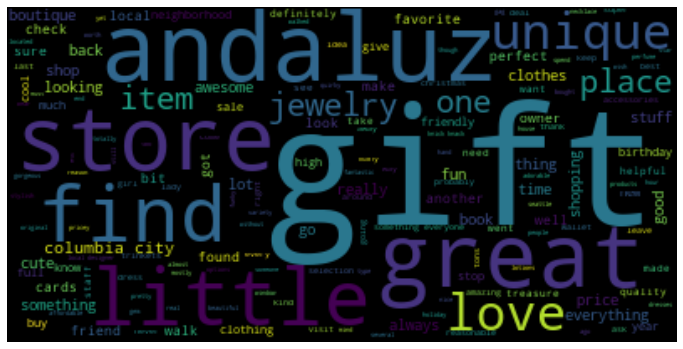

In [37]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(word_cloud_text)

# Display the generated image:
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Coffee Shops

Finally it's time to make some recommendations based on TF-IDF and Count Vectorizer! We will use both vectorization methods and emperically determine which is churning out the best results. 

In [38]:
# first we'd like to create an index with each business name which we may use for future reference
seattle_coffee_indices = pd.Series(seattle_coffee_reviews_grouped.index)
seattle_coffee_indices[:5]

0               Amore’ Coffee
1              Ampersand Cafe
2               Analog Coffee
3    Anchored Ship Coffee Bar
4           Anchorhead Coffee
Name: business_name, dtype: object

### TF-IDF

In [39]:
# initialize 
seattle_coffee_tfidf = TfidfVectorizer()
seattle_coffee_tfidf__matrix = seattle_coffee_tfidf.fit_transform(seattle_coffee_reviews_grouped['bag_of_words'])

In [40]:
# generating the cosine similarity matrix
seattle_coffee_cosine_sim = cosine_similarity(seattle_coffee_tfidf__matrix, seattle_coffee_tfidf__matrix)
seattle_coffee_cosine_sim

array([[1.        , 0.3182056 , 0.4699322 , ..., 0.52679785, 0.46847014,
        0.49476309],
       [0.3182056 , 1.        , 0.28968668, ..., 0.36010738, 0.30824359,
        0.32324302],
       [0.4699322 , 0.28968668, 1.        , ..., 0.47706759, 0.42362823,
        0.4556404 ],
       ...,
       [0.52679785, 0.36010738, 0.47706759, ..., 1.        , 0.4949102 ,
        0.51322502],
       [0.46847014, 0.30824359, 0.42362823, ..., 0.4949102 , 1.        ,
        0.80332386],
       [0.49476309, 0.32324302, 0.4556404 , ..., 0.51322502, 0.80332386,
        1.        ]])

Finally, we will create a recommendation function that accepts a point-of-interest and a cosine similarity matrix as it's inputs and outputs a list of three recommended destinations. 

In [41]:
# function that takes in movie title as input and returns the top 10 recommended movies
def recommendations(business, cosine_sim, indices):
    
    # initialize empty list of recommended businesses
    recommended_businesses = []
    
    # obtain index of business which matches input
    idx = indices[indices == business].index[0]

    # creating series with the similarity scores in descending order, convert to list
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # create list of indices for top three businesses
    score_series_list = list(score_series.index[1:6])

    # add top three recommended businesses to list
    for idx in score_series_list:
        recommended_businesses.append(indices[idx])
        
    return recommended_businesses

In [42]:
recommendations('Analog Coffee', seattle_coffee_cosine_sim, seattle_coffee_indices)

['Capitol Coffee Works',
 'C & P Coffee Company',
 'Down Pour Coffee Bar',
 'Street Bean Coffee Roasters',
 'Broadcast Coffee Roasters']

## Boutique Shops

In [43]:
# first we'd like to create an index with each business name which we may use for future reference
seattle_boutique_indices = pd.Series(seattle_boutique_reviews_grouped.index)
seattle_boutique_indices[:5]

0    Alexandra’s Designer Consignment
1                             Andaluz
2           Ballard Consignment Store
3                       Beats & Bohos
4                  Bon Voyage Vintage
Name: business_name, dtype: object

### TF-IDF

In [44]:
# initialize tf-idf vectorizer
seattle_boutique_tfidf = TfidfVectorizer()
seattle_boutique_tfidf__matrix = seattle_boutique_tfidf.fit_transform(seattle_boutique_reviews_grouped['bag_of_words'])

In [45]:
# generating the cosine similarity matrix
seattle_boutique_cosine_sim = cosine_similarity(seattle_boutique_tfidf__matrix, seattle_boutique_tfidf__matrix)
seattle_boutique_cosine_sim

array([[1.        , 0.20599322, 0.26273978, ..., 0.11065092, 0.22884236,
        0.15558985],
       [0.20599322, 1.        , 0.25984483, ..., 0.1196268 , 0.24582439,
        0.18075392],
       [0.26273978, 0.25984483, 1.        , ..., 0.17285441, 0.27229215,
        0.20062275],
       ...,
       [0.11065092, 0.1196268 , 0.17285441, ..., 1.        , 0.16011892,
        0.09639615],
       [0.22884236, 0.24582439, 0.27229215, ..., 0.16011892, 1.        ,
        0.15946795],
       [0.15558985, 0.18075392, 0.20062275, ..., 0.09639615, 0.15946795,
        1.        ]])

In [46]:
recommendations('Beats & Bohos', seattle_boutique_cosine_sim, seattle_boutique_indices)

['Fremont Vintage Mall',
 'Lifelong Thrift Store',
 'Gold Dogs',
 'Bon Voyage Vintage',
 'Pretty Parlor']

## Adult Entertainment

In [47]:
# first we'd like to create an index with each business name which we may use for future reference
seattle_adult_indices = pd.Series(seattle_adult_reviews_grouped.index)
seattle_adult_indices[:5]

0                  9 LB Hammer
1            909 Coffee & Wine
2                Aluel Cellars
3    Amelia Wynn Winery Bistro
4                   Bad Bishop
Name: business_name, dtype: object

### TF-IDF

In [48]:
# initialize tf-idf vectorizer
seattle_adult_tfidf = TfidfVectorizer()
seattle_adult_tfidf__matrix = seattle_boutique_tfidf.fit_transform(seattle_boutique_reviews_grouped['bag_of_words'])

In [49]:
# generating the cosine similarity matrix
seattle_adult_cosine_sim = cosine_similarity(seattle_adult_tfidf__matrix, seattle_adult_tfidf__matrix)
seattle_adult_cosine_sim

array([[1.        , 0.20599322, 0.26273978, ..., 0.11065092, 0.22884236,
        0.15558985],
       [0.20599322, 1.        , 0.25984483, ..., 0.1196268 , 0.24582439,
        0.18075392],
       [0.26273978, 0.25984483, 1.        , ..., 0.17285441, 0.27229215,
        0.20062275],
       ...,
       [0.11065092, 0.1196268 , 0.17285441, ..., 1.        , 0.16011892,
        0.09639615],
       [0.22884236, 0.24582439, 0.27229215, ..., 0.16011892, 1.        ,
        0.15946795],
       [0.15558985, 0.18075392, 0.20062275, ..., 0.09639615, 0.15946795,
        1.        ]])

In [50]:
recommendations('Aluel Cellars', seattle_adult_cosine_sim, seattle_adult_indices)

['Bottlehouse', 'Fremont Brewing', 'Claret Wine Bar', 'Cepae', 'Cafe Mia']